<a href="https://colab.research.google.com/github/yellowflickerbeat/FakeNews_Detection/blob/main/100_with_retesting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import pandas as pd
import re
from nltk.corpus import stopwords
#stopwords removes all the repetative words which don't substance to the text
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
#WordNetLemmatizer converts words into their roots considering its context
from sklearn.feature_extraction.text import TfidfVectorizer
#TfidfVectorizer measures importance of diff words
from sklearn.model_selection import train_test_split
#splits data into test and train
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [1]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [23]:
#mounting the mandatory datasets
news = pd.read_table('/content/test.tsv')
news.shape
news.head(5)

,Unnamed: 0,title,text,subject,date,label
0,8104,Conservatives Will HATE What Donald Trump Just...,Donald Trump isn t exactly a stranger to makin...,News,"February 14, 2016",0
1,7467,Trump victory may create new tension between U...,Donald Trump’s U.S. election victory may creat...,politicsNews,"November 9, 2016",1
2,9473,WATCH: Hundreds of ILLEGAL ALIENS Storm Senate...,A couple of quick questions come to mind when ...,politics,"Nov 9, 2017",0
3,276,"Democratic Senator Franken to resign: CNN, cit...",U.S. Democratic Senator Al Franken will announ...,politicsNews,"December 7, 2017",1
4,19274,GANG OF DOMESTIC TERRORISTS Violently Attack L...,***WARNING*** Violence is graphic***This Trump...,left-news,"Jan 21, 2017",0


In [24]:
news = news.rename(columns={'Unnamed: 0' : 'id'})
#find out missing values in dataset
news.isnull().sum()

,0
id,0
title,0
text,0
subject,0
date,0
label,0


In [25]:
Y = news['label']
#news = news.drop('label', axis=1)
print(Y)

0       0
1       1
2       0
3       1
4       0
       ..
8262    1
8263    1
8264    0
8265    0
8266    0
Name: label, Length: 8267, dtype: int64


In [8]:
!pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.4 MB/s eta 0:00:00


In [26]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
def get_sentiment_features(text):
    scores = analyzer.polarity_scores(text)
    return scores['neg'], scores['neu'], scores['pos'], scores['compound']

# Apply the sentiment analysis function to the dataset
news[['neg', 'neu', 'pos', 'compound']] = news['title'].apply(get_sentiment_features).apply(pd.Series)

# Prepare the feature set and target variable
X = news[['neg', 'neu', 'pos', 'compound']]  # Use VADER sentiment features
#y = news['label']  # 1 for real, 0 for fake

# Train-test split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [27]:
Y_test = Y_test.dropna().reset_index(drop=True)
X_test, Y_test = X_test.align(Y_test, join='inner', axis=0)
print(Y_train.isnull().sum(), Y_test.isnull().sum())

0 0


In [28]:
y_train_cleaned = Y_train.dropna()

# Align X_train by keeping only the rows that correspond to the non-NaN values in y_train_cleaned
X_train_cleaned = X_train.loc[y_train_cleaned.index]

# Reset the indices of both X_train_cleaned and y_train_cleaned
X_train_cleaned = X_train_cleaned.reset_index(drop=True)
y_train_cleaned = y_train_cleaned.reset_index(drop=True)

# Now check for null values in the cleaned data
print("y_train_cleaned NaN values:", y_train_cleaned.isnull().sum())
print("X_train_cleaned NaN values:", X_train_cleaned.isnull().sum())
print("Y_test NaN values:", Y_test.isnull().sum())

y_train_cleaned NaN values: 0
X_train_cleaned NaN values: neg         0
neu         0
pos         0
compound    0
dtype: int64
Y_test NaN values: 0


In [29]:
model = LogisticRegression()
model.fit(X_train_cleaned, y_train_cleaned)

# Evaluate the model
y_pred = model.predict(X_test)
accuracy = accuracy_score(Y_test, y_pred)
print(f"Model Accuracy: {accuracy:.3f}")

Model Accuracy: 0.468


In [30]:
from sklearn.ensemble import RandomForestClassifier
import textstat

fake_news_words = [
    "Exclusive", "Shocking", "Revealed", "Exposed", "Unbelievable",
    "Scandal", "Unprecedented", "Breaking", "Conspiracy", "Hoax",
    "Bombshell", "Alert", "Hacked", "Disturbing", "Cover-up",
    "Unfounded", "Widespread", "Propaganda", "Debunked", "Controversial", "Alien"
]

def contains_fake_news_keywords(text, keywords):
    tokens = text.split()  # Assuming text is already cleaned and tokenized
    return any(keyword in tokens for keyword in keywords)

# Function to calculate average sentence length
def average_sentence_length(text):
    sentences = text.split('.')  # Split text into sentences (basic splitting)
    num_sentences = len([s for s in sentences if s.strip()])
    num_words = len(text.split())
    return num_words / num_sentences if num_sentences > 0 else 0

def flesch_kincaid_score(text):
    return textstat.flesch_kincaid_grade(text)

# Apply feature engineering before splitting the data
news['keyword_feature'] = news['title'].apply(lambda x: contains_fake_news_keywords(x, fake_news_words)) | \
                          news['text'].apply(lambda x: contains_fake_news_keywords(x, fake_news_words))

news['avg_sentence_length'] = news['text'].apply(average_sentence_length)
news['flesch_kincaid'] = news['text'].apply(flesch_kincaid_score)

# Combine VADER sentiment features and keyword feature
X = news[['neg', 'neu', 'pos', 'compound', 'keyword_feature', 'avg_sentence_length', 'flesch_kincaid']]

# Now split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Handle NaN values in y_train
y_train_cleaned = Y_train.dropna()
X_train_cleaned = X_train.loc[y_train_cleaned.index].reset_index(drop=True)
y_train_cleaned = y_train_cleaned.reset_index(drop=True)

# Train a simple model (Random Forest Classifier)
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_cleaned, y_train_cleaned)

y_pred = clf.predict(X_test)
accuracy = accuracy_score(Y_test, y_pred)
print(f"Model Accuracy: {accuracy:.4f}")

Model Accuracy: 0.7932


In [31]:
!pip install textstat

In [33]:
from sklearn.preprocessing import OneHotEncoder

# One-hot encode the subject names
encoder = OneHotEncoder()
subject_encoded = encoder.fit_transform(news[['subject']]).toarray()

# Add subject encoding as new features
subject_columns = [f"subject_{cat}" for cat in encoder.categories_[0]]
subject_df = pd.DataFrame(subject_encoded, columns=subject_columns)

# Combine with existing features
X = pd.concat([news[['neg', 'neu', 'pos', 'compound', 'keyword_feature', 'avg_sentence_length', 'flesch_kincaid']],
               subject_df], axis=1)
Y = news['label']  # Target variable

# Handle NaN values
X.fillna(0, inplace=True)
Y.fillna(0, inplace=True)

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Train a Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, Y_train)

# Make predictions
y_pred = clf.predict(X_test)
accuracy = accuracy_score(Y_test, y_pred)

print(f"Model Accuracy (With Subject Features): {accuracy:.4f}")


Model Accuracy (With Subject Features): 1.0000


In [34]:
from sklearn.utils import shuffle

Y_shuffled = shuffle(Y)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y_shuffled, test_size=0.2, random_state=42)
clf.fit(X_train, Y_train)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(Y_test, y_pred)
print(f"Accuracy with Shuffled Labels: {accuracy:.4f}")

Accuracy with Shuffled Labels: 0.4891


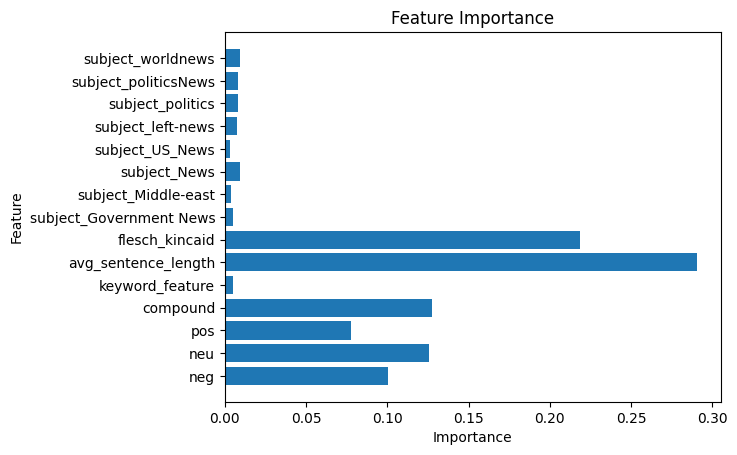

In [35]:
import matplotlib.pyplot as plt

feature_importances = clf.feature_importances_
plt.barh(X.columns, feature_importances)
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance")
plt.show()